# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you dont need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2} $$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [1]:
# !pip install pytorch_lightning &> /dev/null
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
# import pytorch_lightning as pl
# import pytorch_lightning.loggers as pl_loggers
# import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# # Use this function to import the provided data files
# def load_data(file_name):
#     return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

# images = load_data('/content/drive/Shareddrives/CIS 680/Project 2 YOLO/Data/images.npz')
# raw_labels = load_data('/content/drive/Shareddrives/CIS 680/Project 2 YOLO/Data/labels.npz')

In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
  return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz')
raw_labels = load_data('labels.npz')
# yolo_loss_data = np.load('test_yolo_loss.npz', allow_pickle=True, encoding='latin1')


In [4]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    raw_labels = raw_labels[0]
     #initialize labels with all 0s 
    labels= np.zeros((8,8,8))

    grid_size= 16
    no_of_grids= 8
    # get classes
    label= raw_labels[:,0].astype(int)
    #P(class) 1 at 5th index if raw_label[0]= 0, at 6th index if raw_label[0]= 1, at 7th index if raw_label[0]= 2 
    label_idx = label + 5 #indexes 5,6,7
    # print(label_idx)

    #calculate centres for that image
    x1= raw_labels[:,1]
    x2= raw_labels[:,3]
    x_img= (x1 + x2)/2

    y1= raw_labels[:,2]
    y2= raw_labels[:,4]
    y_img= (y1 + y2)/2


    #Coordinates of centre w.r.t the grid 
    x= (x_img%grid_size)/grid_size
    y= (y_img%grid_size)/grid_size

    # print(x)
    # print(y)

    #calculate width and height (x2-x1) and (y2-y1)
    w= (x2- x1)/128
    h= (y2- y1)/128

    #grid coordinates
    grid_x = np.floor(x_img/grid_size).astype(int)
    # print(grid_x)
    grid_y = np.floor(y_img/grid_size).astype(int)
    # print(grid_y)

    #P(objectness)
    labels[0, grid_x, grid_y] = 1

    #x,y,w,h
    labels[1, grid_x, grid_y] = x
    labels[2, grid_x, grid_y] = y
    labels[3, grid_x, grid_y] = w
    labels[4, grid_x, grid_y] = h

    #P(Pedestrian), P(Traffic Light), P(Car)
    for i in range(grid_x.shape[0]):
      if label_idx[i]==5:
         labels[5, grid_x[i], grid_y[i]] =1
         labels[6, grid_x[i], grid_y[i]] =0
         labels[7, grid_x[i], grid_y[i]] =0
      if label_idx[i]==6:
         labels[5, grid_x[i], grid_y[i]] =0
         labels[6, grid_x[i], grid_y[i]] =1
         labels[7, grid_x[i], grid_y[i]] =0
      if label_idx[i]==7:
         labels[5, grid_x[i], grid_y[i]] =0
         labels[6, grid_x[i], grid_y[i]] =0
         labels[7, grid_x[i], grid_y[i]] =1

    return labels

In [5]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
      result= np.where(labels[0]==1)
      label_idx=[]
      for i in range(result[0].shape[0]):
        if (labels[5][result[0][i]][result[1][i]] ==1):
          label_idx.append(0)
        if (labels[6][result[0][i]][result[1][i]] ==1):
          label_idx.append(1)
        if (labels[7][result[0][i]][result[1][i]] ==1):
          label_idx.append(2)

      # print(label_idx)

      x = labels[1, result[0], result[1]]
      y = labels[2, result[0], result[1]]
      X = 16*x + 16*result[0]
      Y = 16*y + 16*result[1]
      W = labels[3, result[0], result[1]]*128
      H= labels[4, result[0], result[1]]*128

      x1= X - W/2
      y1= Y - H/2
      x2= X + W/2
      y2= Y + H/2

      raw_labels =[]
      for i in range(x1.shape[0]):
        raw_labels.append([label_idx[i], x1[i], y1[i], x2[i], y2[i]])

      return np.array(raw_labels)

In [6]:
labels = []
for i in range (raw_labels.shape[0]):
  labels.append(process_labels(np.expand_dims(raw_labels[i], axis=0)))

labels = torch.tensor(np.array(labels))

In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Creating a torch dataset from images and labels
class MyDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
      return self.images.shape[0]
        
    def __getitem__(self, idx):
        images = self.transform(self.images[idx, :, :, :])
        labels = self.labels[idx]

        return images, labels

# Splitting data for training and testing

dataset = MyDataset(images, labels, transform = torchvision.transforms.ToTensor())
length = len(dataset) 
# print(length)
train_len = int(0.8*length)
test_len = length - train_len
train_data, test_data = random_split(dataset, [train_len, test_len])
# print(len(train_data))


In [8]:
train_loader = DataLoader(train_data, batch_size=64, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, num_workers=2)

In [9]:
def int_over_uni(bb_op, bb_target):
  #bb_op and bb_target have shape [x,y,w,h]
  out_x =  bb_op[:, 0, :, :]*16
  out_y =  bb_op[:, 1, :, :]*16
  out_w = bb_op[:, 2, :, :]*128
  out_h = bb_op[:, 3, :, :]*128

  ox1 = out_x - out_w/2 
  oy1 = out_y - out_h/2
  ox2 = out_x + out_w/2
  oy2 = out_y + out_h/2
  o_area = (ox2 - ox1)*(oy2 - oy1)
  # print("o area", o_area)

  tgt_x = bb_target[:, 0, :, :]*16
  tgt_y = bb_target[:, 1, :, :]*16
  tgt_w = bb_target[:, 2, :, :]*128
  tgt_h = bb_target[:, 3, :, :]*128
  
  tx1 = tgt_x - tgt_w/2
  ty1 = tgt_y - tgt_h/2
  tx2 = tgt_x + tgt_w/2
  ty2 = tgt_y + tgt_h/2
  t_area = (tx2 - tx1)*(ty2 - ty1)
  # print("t_area", t_area)

  x1 = torch.max(ox1, tx1)
  y1 = torch.max(oy1, ty1)
  x2 = torch.min(ox2, tx2)
  y2 = torch.min(oy2, ty2)

  intersection = (x2-x1)*(y2-y1)
  intersection[x2-x1 <0] =0
  intersection[y2-y1<0]=0
  
  # print("inter", intersection)
  iou = intersection / (o_area + t_area - intersection + 1e-6)
  # print("IOU", iou)
  return iou

In [10]:
def yolo_loss(output, target):

    lam1 = 5
    lam2 =0.5
    # op shape is CxSxS, C = [Pr(Obj), x, y, w, h, p(c1), p(c2), p(c3)]

    bb_op = output[:, 1:5, :, :].clone() #bounding box from output with(x,y,w,h)
    bb_target = target[:, 1:5, :, :] #bounding box from target with(x,y,w,h)
    iou = int_over_uni(bb_op, bb_target)
    do_we_have_obj = target[:, 0, :, :] #Pr(Obj) from target
    do_we_have_obj_op = output[:, 0, :, :].clone() #Pr(Obj) from output

    # FOR BBox COORD LOSS
    bbox_pred = bb_op # if obj is there in op bbox
    bbox_target = bb_target # if obj is there in tgt bbox
    bbox_pred[:, 2:4, :, :] = torch.sqrt(bbox_pred[:, 2:4, :, :])
    bbox_target[:, 2:4, :, :] = torch.sqrt(bbox_target[:, 2:4, :, :]) 
    # print("pred shape", bbox_pred.shape)
    # print("tgt shape", bbox_target.shape)
    # print("do we", do_we_have_obj.shape)
    # bbox_loss = lam1 * torch.sum(do_we_have_obj *(bbox_pred - bbox_target)**2)
    bbox_loss = lam1 * torch.sum(do_we_have_obj * ((bbox_pred[:, 0, :, :] - bbox_target[:, 0, :, :])**2 + (bbox_pred[:, 1, :, :] - bbox_target[:, 1, :, :])**2)) +\
                lam1 * torch.sum(do_we_have_obj *((bbox_pred[:, 2, :, :] - bbox_target[:, 2, :, :])**2 + (bbox_pred[:, 3, :, :] - bbox_target[:, 3, :, :])**2))
  
    # print("bbox loss",bbox_loss)

    # FOR OBJECT LOSS
    # if IOU is (almost) 1, loss should (almost) be zero bcz obj exists in cell
    t1 = do_we_have_obj_op 
    t2 = do_we_have_obj * iou
    obj_loss = torch.sum(((do_we_have_obj) * (t2-t1)**2))
    # print("obj loss", obj_loss)

    # FOR NO OBJECT LOSS
    # if IOU is (almost) 0, loss should (almost) be zero bcz obj DNE in cell
    t3 = do_we_have_obj_op 
    t4 = do_we_have_obj * iou
    no_obj_loss = lam2 *  torch.sum((1 - do_we_have_obj) * ((t4-t3)**2))
    # print("no obj loss", no_obj_loss)

    # FOR CLASS LOSS
    class_pred =  output[:, 5:8, :, :].clone()
    class_target = target[:, 5:8, :, :]
    # class_loss = torch.sum(do_we_have_obj * (class_pred - class_target)**2)
    class_loss = torch.sum(do_we_have_obj * ((class_pred[:,0,:,:] - class_target[:,0,:,:])**2 + (class_pred[:,1,:,:] - class_target[:,1,:,:])**2 + (class_pred[:,2,:,:] - class_target[:,2,:,:])**2))
    # print("class loss", class_loss)
    
    # loss = bbox cordinate loss + loss for cell has obj + loss for when cell does not have obj + loss for class error
    loss = bbox_loss + obj_loss + no_obj_loss + class_loss
    # print("LOSS HERE", loss)

    return loss

In [23]:
# yolo_loss(torch.tensor(yolo_loss_data['pred'][2]), torch.tensor(yolo_loss_data['target'][2]))

In [12]:
class YOLO(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Sequential(nn.Conv2d(3,32,4,stride=2,padding=1), nn.BatchNorm2d(32),nn.ReLU())
      self.conv2 = nn.Sequential(nn.Conv2d(32,64,4,stride=2, padding=1), nn.BatchNorm2d(64),nn.ReLU())
      self.conv3 = nn.Sequential(nn.Conv2d(64,128,4,stride=2, padding=1), nn.BatchNorm2d(128),nn.ReLU())
      self.conv4 = nn.Sequential(nn.Conv2d(128,256,4,stride=2, padding=1), nn.BatchNorm2d(256),nn.ReLU())
      self.conv5 = nn.Sequential(nn.Conv2d(256,512,4,stride=2, padding=1), nn.BatchNorm2d(512),nn.ReLU())
      self.conv6 = nn.Sequential(nn.Conv2d(512,1024,4,stride=2, padding=1), nn.BatchNorm2d(1024),nn.ReLU())
      self.trans_conv7 = nn.Sequential(nn.ConvTranspose2d(1024,256,4,stride=2, padding=1), nn.BatchNorm2d(256),nn.ReLU())
      self.trans_conv8 = nn.Sequential(nn.ConvTranspose2d(256,64,4,stride=2, padding=1), nn.BatchNorm2d(64),nn.ReLU())
      self.conv9 = nn.Sequential(nn.Conv2d(64,8,3,stride=1, padding=1), nn.Sigmoid())
      

  def forward(self, x):
      out= self.conv1(x)
      out= self.conv2(out)
      out= self.conv3(out)
      out= self.conv4(out)
      out= self.conv5(out)
      out= self.conv6(out)
      out= self.trans_conv7(out)
      out= self.trans_conv8(out)
      out= self.conv9(out)
      return out 

model = YOLO().to(device)


In [26]:
# from torchsummary import summary
# summary(model, (3, 128, 128))

In [ ]:
def low_confidence_suppression(label):
    ...
    return label

def non_max_suppression(label):
    ...
    return label

In [ ]:
def precision_recall_curve(predictions, targets, target_class):
    ...
    return recall, precision

def average_precision(predictions, targets, target_class):
    ...
    return average_precision

def mean_average_precision(predictions, targets):
    ...
    return mean_average_precision

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

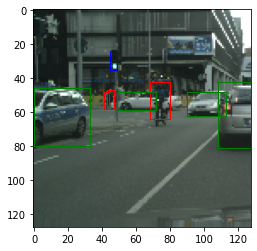

In [13]:
# Show the chosen image with ground truth bounding boxes visualized.
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image= images[8]
raw_label = raw_labels[8]
image_width= 128
image_height=128

num_boxes = raw_label.shape[0]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(image)

for i in range(num_boxes):
  width = raw_label[i][3] - raw_label[i][1]
  height = raw_label[i][4] - raw_label[i][2]
  x_center= (raw_label[i][1] + raw_label[i][3])/2 
  y_center= (raw_label[i][2] + raw_label[i][4])/2 

  if(raw_label[i][0] == 0):
    rect = patches.Rectangle((x_center-width/2,y_center-height/2),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  if(raw_label[i][0] == 1):
    rect = patches.Rectangle((x_center-width/2,y_center-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
  if(raw_label[i][0] == 2):
    rect = patches.Rectangle((x_center-width/2,y_center-height/2),width,height,linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

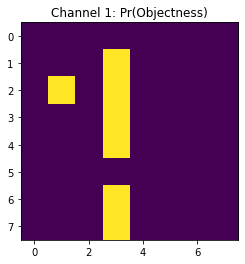

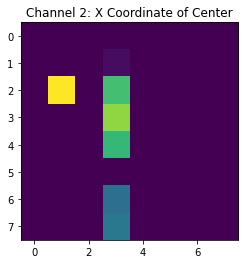

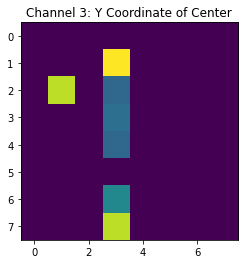

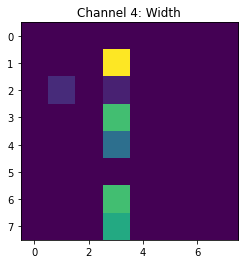

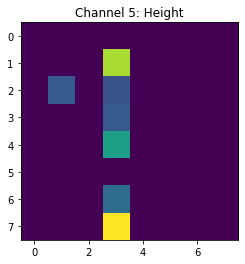

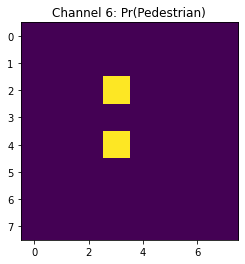

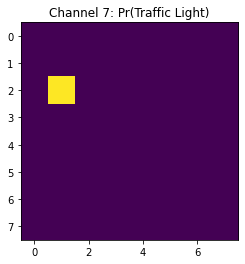

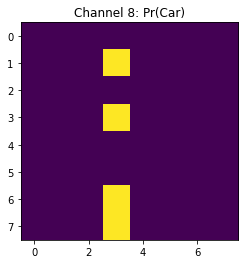

In [14]:
# Visualize the 8x8x8 representation

labels = process_labels(np.expand_dims(raw_labels[8], axis=0))

#Channel 1: P(Objectness)
plt.imshow(labels[0])
plt.title("Channel 1: Pr(Objectness)")
plt.show()

#Channel 2: X
plt.imshow(labels[1])
plt.title("Channel 2: X Coordinate of Center")
plt.show()
  
#Channel 3: Y
plt.imshow(labels[2])
plt.title("Channel 3: Y Coordinate of Center")
plt.show()
  
#Channel 4: Width
plt.imshow(labels[3])
plt.title("Channel 4: Width")
plt.show()

#Channel 5: Height
plt.imshow(labels[4])
plt.title("Channel 5: Height")
plt.show()

#Channel 2: P(Pedestrian)
plt.imshow(labels[5])
plt.title("Channel 6: Pr(Pedestrian)")
plt.show()
  
#Channel 3: P(Traffic Light)
plt.imshow(labels[6])
plt.title("Channel 7: Pr(Traffic Light)")
plt.show()
  
#Channel 4: P(Car)
plt.imshow(labels[7])
plt.title("Channel 8: Pr(Car)")
plt.show()

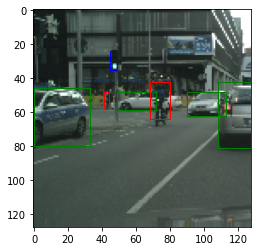

In [15]:
# Convert back to the original representation (test cases below should pass).
raw_label = reconstruct_raw_labels(labels)

image= images[8]
image_width= 128
image_height=128

num_boxes = raw_label.shape[0]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(image)

for i in range(num_boxes):
  width = raw_label[i][3] - raw_label[i][1]
  height = raw_label[i][4] - raw_label[i][2]
  x_center= (raw_label[i][1] + raw_label[i][3])/2 
  y_center= (raw_label[i][2] + raw_label[i][4])/2 

  if(raw_label[i][0] == 0):
    rect = patches.Rectangle((x_center-width/2,y_center-height/2),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  if(raw_label[i][0] == 1):
    rect = patches.Rectangle((x_center-width/2,y_center-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
  if(raw_label[i][0] == 2):
    rect = patches.Rectangle((x_center-width/2,y_center-height/2),width,height,linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

2. Implement the loss function. (3%)

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

The only change made to the architecture was that after the last convolution operation we passed it through the sigmoid activation function since here the object detection problem is being treated as a regression problem.

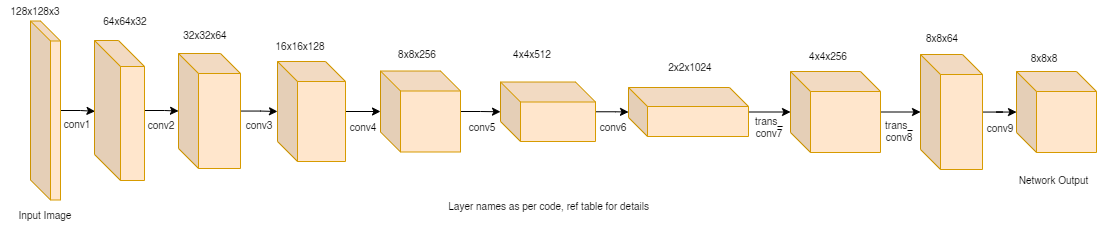

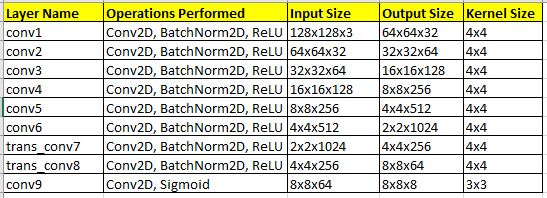

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [18]:
# Setup your training
def train(model, device, train_loader, validation_loader, epochs, optimizer):

    train_loss, validation_loss = [], []
    # train_acc, validation_acc = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 

        for batch_idx, (data, target) in enumerate(train_loader):
      
                data, target = data.to(device), target.to(device)
              
                output = model.forward(data)
                
                optimizer.zero_grad()
                loss = yolo_loss(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                

        train_loss.append(running_loss/len(train_loader)) 
        print("Loss for epoch " + str(epoch+1) + "= "+ str(running_loss/len(train_loader)))

                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with torch.no_grad():
          for data, target in test_loader:
                data = data.float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = yolo_loss(output, target)
                running_loss += loss.item()

        validation_loss.append(running_loss/len(validation_loader))
         
    
    return train_loss, validation_loss

In [23]:
# Train your model
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.0005)
num_epochs = 50
train_loss, validation_loss = train(model, device, train_loader, test_loader, num_epochs, optimizer)

Loss for epoch 1= 15.26522463720214
Loss for epoch 2= 11.059963244144775
Loss for epoch 3= 9.059857101622512
Loss for epoch 4= 7.759963892043929
Loss for epoch 5= 6.847968259887443
Loss for epoch 6= 6.1681241167343615
Loss for epoch 7= 5.635904000526569
Loss for epoch 8= 5.209199232579031
Loss for epoch 9= 4.860373963679576
Loss for epoch 10= 4.589956027424286
Loss for epoch 11= 4.377978205073141
Loss for epoch 12= 4.181845865263159
Loss for epoch 13= 3.988157378791169
Loss for epoch 14= 3.859301867608733
Loss for epoch 15= 3.744787927259992
Loss for epoch 16= 3.7020158431881875
Loss for epoch 17= 3.655178022730815
Loss for epoch 18= 3.6469355375945245
Loss for epoch 19= 3.631443363243457
Loss for epoch 20= 3.4766881775940823
Loss for epoch 21= 3.3587118621080747
Loss for epoch 22= 3.2439017658631966
Loss for epoch 23= 3.157562085886685
Loss for epoch 24= 3.131393898216209
Loss for epoch 25= 3.1293291788842
Loss for epoch 26= 3.175197140184948
Loss for epoch 27= 3.1876403579391166
Loss

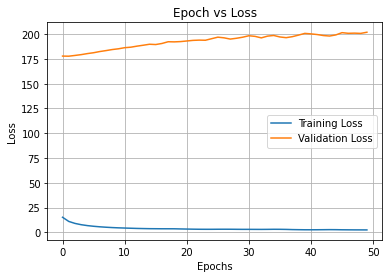

In [24]:
# Plot the results
epochs = len(train_loss)
fig, ax1 = plt.subplots(1, 1)

ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Epoch vs Loss')
plt.grid()
ax1.legend()
plt.show()

5. Show a plot of the mean Average Precision over training for your model. (10%)

In [ ]:
...

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

In [ ]:
...

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

In [ ]:
...

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [ ]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf cis680_hw2.ipynb